In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numba import jit

## Set up a sample img

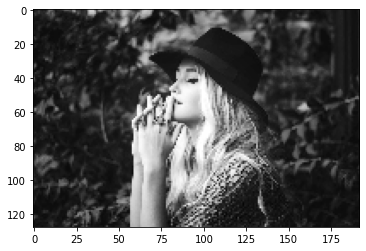

In [2]:
sample_img = cv2.imread('./sample_img.jpeg', cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255
sample_img = cv2.resize(sample_img, dsize=(96*2, 64*2))
plt.imshow(sample_img, cmap='gray')

## Set up a weighted graph G = (V, E)

$$
\begin{aligned}
w_{ij} = e^{\frac{-||\mathbf{F}_{(i)} - \mathbf{F}_{(j)}||_2^2}{\sigma_I^2}} *
\begin{cases}
    e^{\frac{-||\mathbf{X}_{(i)} - \mathbf{X}_{(j)}||_2^2}{\sigma_X^2}}       & \quad \text{if } ||\mathbf{X}_{(i)} - \mathbf{X}_{(j)}||_2 < r \\[1em]
    0  & \quad \text{otherwise}
\end{cases}
\end{aligned}
$$

In [3]:
@jit(nopython=True)
def cal_dist_weighted_matrix(size, r, sig_X):
    h, w = size
    X_matrix = np.zeros((h*w, h*w))
    for i in range(h*w):
        for j in range(h*w):
            i_row, i_col = i // w, i % w
            j_row, j_col = j // w, j % w
            dist = np.power(i_row - j_row, 2) + np.power(i_col - j_col, 2)
            
            if np.sqrt(dist) < r:    
                X_matrix[i, j] = np.exp(-dist / sig_X)
    return X_matrix
    
def set_weighted_matrix(img, sig_I=0.01, sig_X=5, r=10):
    vec_img = img.flatten()
    F_matrix = np.power(vec_img[None, :] - vec_img[:, None], 2)
    F_matrix /= sig_I
    F_matrix = np.exp(-F_matrix)
    
    X_matrix = cal_dist_weighted_matrix(img.shape, r, sig_X)
    return F_matrix * X_matrix

In [4]:
%%time
weighted_matrix = set_weighted_matrix(sample_img)

CPU times: user 15.5 s, sys: 10.3 s, total: 25.7 s
Wall time: 20.3 s


## Solve the generalized eigensystem
$$
\mathbf{D}^{-\frac{1}{2}}(\mathbf{D} - \mathbf{W})\mathbf{D}^{-\frac{1}{2}}\mathbf{x} = \lambda\mathbf{x}
$$


In [8]:
D = np.diag(np.sum(weighted_matrix, axis=1))
sqrt_inverse_D = np.diag(1 / np.sqrt(np.sum(weighted_matrix, axis=1)))

matrix_representation = np.dot(sqrt_inverse_D, np.dot((D - weighted_matrix), sqrt_inverse_D))

In [9]:
%%time
eigenvalues, eigenvectors = np.linalg.eig(matrix_representation)

CPU times: user 1d 4h 27min, sys: 1d 19h 38min 2s, total: 3d 5min 3s
Wall time: 1h 14min 56s


## Partitioning the graph into segmented pieces

In [10]:
h = 64 * 2
w = 96 * 2

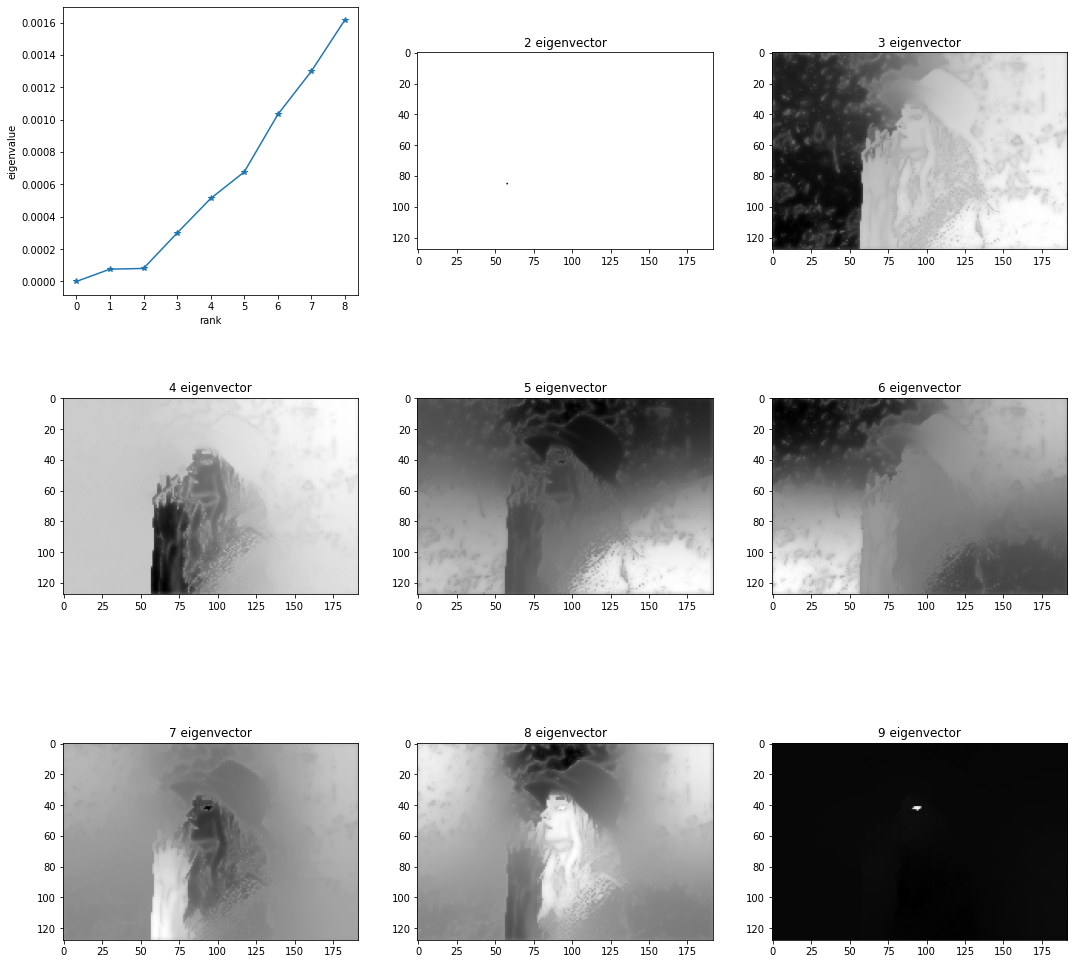

In [11]:
for i in range(9):
    if i == 0:
        plt.figure(figsize=(18,18))
        plt.subplot(3,3,1)
        plt.plot(range(0, 9), np.sort(eigenvalues)[:9], '*-')
        plt.xlabel('rank')
        plt.ylabel('eigenvalue')
    else:
        plt.subplot(3,3,i+1)
        index = np.argsort(eigenvalues)[i]
        partition = eigenvectors[:, index]
        plt.imshow(np.reshape(partition, (h, w)).astype(np.float32), cmap='gray')
        plt.title(str(i+1) + " eigenvector")
plt.show()